<a href="https://colab.research.google.com/github/mrpranavr/Corona-prediction-deep-model/blob/main/Corona_prediction_districts.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# District wise corona prediction

## Preparing the datasets

In [ ]:
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import layers
import os

In [ ]:
def plot_time_series(timesteps,values,format = '.', start = 0,end = None,label = None):
    plt.plot(timesteps[start:end], values[start:end], format , label = label)
    plt.xlabel("Time")
    plt.ylabel("Cases")
    if label:
        plt.legend(fontsize = 14)
    plt.grid();

In [ ]:
def evaluate_preds(y_true,y_pred):
    y_true = tf.cast(y_true, dtype = tf.float32)
    y_pred = tf.cast(y_pred, dtype = tf.float32)

    mae = tf.keras.metrics.mean_absolute_error(y_true,y_pred)
    mse = tf.keras.metrics.mean_squared_error(y_true,y_pred)
    rmse = tf.sqrt(mse)
    mape = tf.keras.metrics.mean_absolute_percentage_error(y_true,y_pred)

    if mae.ndim > 0:
        mae = tf.reduce_mean(mae)
        mse = tf.reduce_mean(mse)
        rmse = tf.reduce_mean(rmse)
        mape = tf.reduce_mean(mape)

    return {"mae": mae.numpy(),
            "mse": mse.numpy(),
            "rmse": rmse.numpy(),
            "mape": mape.numpy()}

In [ ]:
def get_labelled_window(x,horizon = 7):
    return x[:,:-horizon], x[:,-horizon:]

In [ ]:
def make_windows(x,window_size = 7,horizon = 1):
    window_step = np.expand_dims(np.arange(window_size + horizon), axis = 0)
    window_indexes = window_step + np.expand_dims(np.arange(len(x) - (window_size+horizon+1)),axis = 0).T
    windowed_array = x[window_indexes]
    windows,labels = get_labelled_window(windowed_array,horizon = horizon)
    return windows, labels

In [ ]:
def make_train_test_split(windows,labels,test_split = 0.2):
    split_size = int(len(windows)*(1-test_split))
    train_windows = windows[:split_size]
    train_labels = labels[:split_size]
    test_windows = windows[split_size:]
    test_labels = labels[split_size:]
    return train_windows,test_windows,train_labels,test_labels

In [ ]:
def create_model_checkpoint(model_name, save_path = "model_experiments"):
    return tf.keras.callbacks.ModelCheckpoint(filepath = os.path.join(save_path,model_name),
                                              verbose = 0,
                                              save_best_only = True)

In [ ]:
def make_preds(model_name, test_dataset):
    preds = model_name.predict(test_dataset)
    return tf.squeeze(preds)

In [ ]:
# df = pd.read_csv('/content/District .csv')
# df['date'] = pd.to_datetime(df['date'],format = '%d/%m/%Y')
# df = df.set_index('date')
# df = df['Alappuzha']
# df = pd.DataFrame(df)

# # Plot graph
# df.plot(figsize = (10,7))
# plt.ylabel("Cases")
# plt.legend(fontsize = 14)

# # Create timesteps and cases

# timesteps = df.index.to_numpy()
# cases = df['Alappuzha'].to_numpy()
# cases = cases.astype(np.float32)
# # print(len(cases))
# df

In [ ]:
def load_and_prepare_datasets(filename,district_name, horizon, window_size):
    # Load the dataset
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'],format = '%d/%m/%Y')
    df = df.set_index('date')
    df = df[district_name]
    df = pd.DataFrame(df)

    # Plot graph
    df.plot(figsize = (10,7))
    plt.ylabel("Cases")
    plt.legend(fontsize = 14)

    # Create timesteps and cases
    timesteps = df.index.to_numpy()
    cases = df[district_name].to_numpy()
    cases = cases.astype(np.float32)

    # Make data for plotting
    split_size = int(0.8 * len(cases))

    X_train,y_train = timesteps[:split_size], cases[:split_size]
    X_test, y_test = timesteps[split_size:], cases[split_size:]


    # Creating windowed dataste
    full_windows, full_labels = make_windows(cases, window_size = window_size, horizon = horizon)
    train_windows, test_windows, train_labels,test_labels = make_train_test_split(full_windows,full_labels, test_split = 0.2)
    
    return train_windows, test_windows,train_labels,test_labels,X_test

In [ ]:
test_windows[:10]

array([[250., 233., 250., 218., 172., 180., 267.],
       [233., 250., 218., 172., 180., 267., 185.],
       [250., 218., 172., 180., 267., 185., 181.],
       [218., 172., 180., 267., 185., 181., 213.],
       [172., 180., 267., 185., 181., 213., 143.],
       [180., 267., 185., 181., 213., 143., 151.],
       [267., 185., 181., 213., 143., 151., 169.],
       [185., 181., 213., 143., 151., 169., 137.],
       [181., 213., 143., 151., 169., 137., 215.],
       [213., 143., 151., 169., 137., 215., 144.]], dtype=float32)

(527, 132, 527, 132, 135)

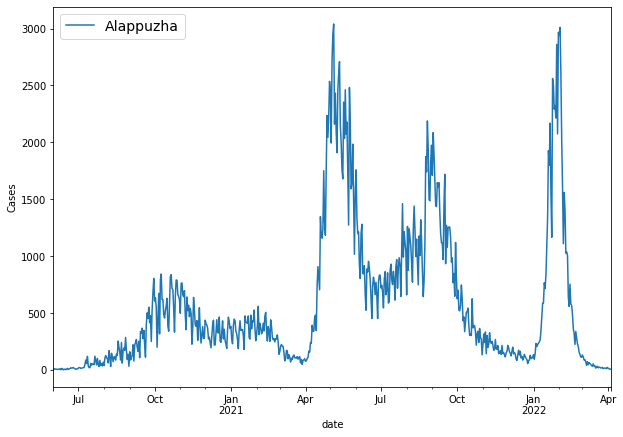

In [ ]:
train_windows, test_windows, train_labels,test_labels,X_test = load_and_prepare_datasets('/content/District .csv','Alappuzha',7,7)
len(train_windows), len(test_windows), len(train_labels), len(test_labels), len(X_test)

## Master Function

In [ ]:
def train_model(train_windows,test_windows,train_labels,test_labels,X_test,horizon,name):
    tf.random.set_seed(42)

    model = tf.keras.Sequential([
        layers.Dense(128, activation = 'relu'),
        layers.Dense(horizon, activation = 'linear')
    ], name = name)

    # compile
    model.compile(loss = 'mae',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['mae'])

    # fit
    model.fit(x = train_windows,
                            y = train_labels,
                            epochs = 100,
                            verbose = 0,
                            batch_size = 128,
                            validation_data = (test_windows, test_labels),
                            callbacks = [create_model_checkpoint(model_name = model.name)])
    
    # Take most efficient model
    model = tf.keras.models.load_model(f"model_experiments/{model.name}")
    model_preds = make_preds(model, test_windows)
    model_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                   y_pred = model_preds)
    
    # Plot the prediction graph
    plt.figure(figsize = (10,7))
    plot_time_series(timesteps = X_test[-len(test_windows):],
                    values = test_labels[:,0],
                    label = 'test_data')
    plot_time_series(timesteps = X_test[-len(test_windows):],
                    values = tf.reduce_mean(model_preds,axis = 1),
                    format = '-',
                    label = model.name
                    )
    
    return model

INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorf

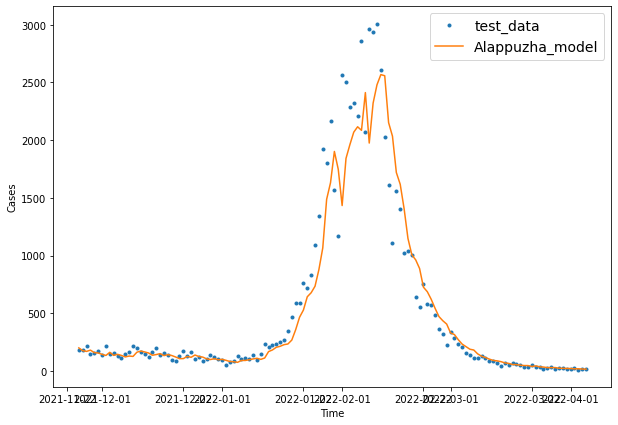

In [ ]:
Alappuzha_model = train_model(train_windows,test_windows,train_labels,test_labels,X_test,horizon = 7,name = 'Alappuzha_model')

In [ ]:
Alappuzha_model.evaluate(test_windows,test_labels)

5/5 [==============================] - 0s 3ms/step - loss: 212.2815 - mae: 212.2815


[212.2815399169922, 212.2815399169922]

In [ ]:
def load_and_train_model(filename,
                         district_name, 
                         horizon, 
                         window_size,
                         name):
    # Load the dataset
    df = pd.read_csv(filename)
    df['date'] = pd.to_datetime(df['date'],format = '%d/%m/%Y')
    df = df.set_index('date')
    df = df[district_name]
    df = pd.DataFrame(df)

    # Plot graph
    df.plot(figsize = (10,7))
    plt.ylabel("Cases")
    plt.legend(fontsize = 14)

    # Create timesteps and cases
    timesteps = df.index.to_numpy()
    cases = df[district_name].to_numpy()
    cases = cases.astype(np.float32)

    # Make data for plotting
    split_size = int(0.8 * len(cases))

    X_train,y_train = timesteps[:split_size], cases[:split_size]
    X_test, y_test = timesteps[split_size:], cases[split_size:]


    # Creating windowed dataste
    full_windows, full_labels = make_windows(cases, window_size = window_size, horizon = horizon)
    train_windows, test_windows, train_labels,test_labels = make_train_test_split(full_windows,full_labels, test_split = 0.2)

    # Model creating and evaluation
    tf.random.set_seed(42)

    model = tf.keras.Sequential([
        layers.Dense(128, activation = 'relu'),
        layers.Dense(horizon, activation = 'linear')
    ], name = name)

    # compile
    model.compile(loss = 'mae',
                    optimizer = tf.keras.optimizers.Adam(),
                    metrics = ['mae'])

    # fit
    model.fit(x = train_windows,
                            y = train_labels,
                            epochs = 100,
                            verbose = 0,
                            batch_size = 128,
                            validation_data = (test_windows, test_labels),
                            callbacks = [create_model_checkpoint(model_name = model.name)])
    
    # Take most efficient model
    model = tf.keras.models.load_model(f"model_experiments/{model.name}")
    model_preds = make_preds(model, test_windows)
    model_results = evaluate_preds(y_true = tf.squeeze(test_labels),
                                   y_pred = model_preds)
    
    # Plot the prediction graph
    plt.figure(figsize = (10,7))
    plot_time_series(timesteps = X_test[-len(test_windows):],
                    values = test_labels[:,0],
                    label = 'test_data')
    plot_time_series(timesteps = X_test[-len(test_windows):],
                    values = tf.reduce_mean(model_preds,axis = 1),
                    format = '-',
                    label = model.name
                    )
    
    return model

### Alappuzha

INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorf

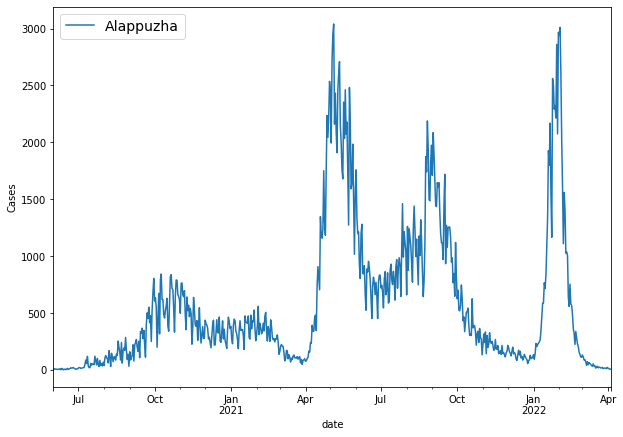

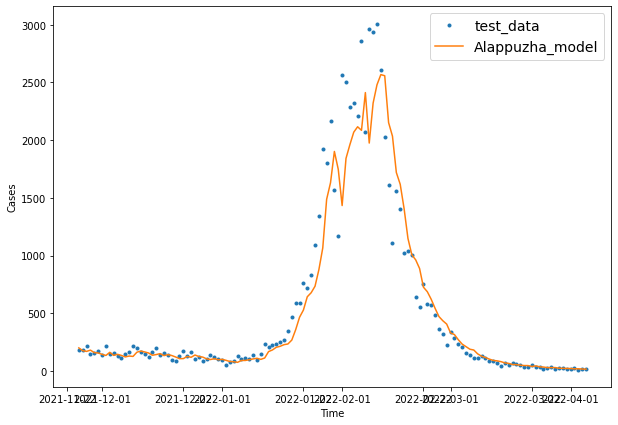

In [ ]:
Alappuzha_model = load_and_train_model(filename = '/content/District .csv',
                                       district_name='Alappuzha',
                                       horizon = 7,
                                       window_size = 7,
                                       name = 'Alappuzha_model')

### Ernakulam

In [ ]:
districts_list = ['Alappuzha',
                  'Ernakulam',
                  'Idduki',
                  'Kannur',
                  'Kasargod',
                  'Kollam',
                  'Kottayam',
                  'Kozhikode',
                  'Malapuram',
                  'Palakad',
                  'Pathanamthitta',
                  'Thrissur',
                  'Trivandrum',
                  'Wayanad',
                  ]

INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorflow:Assets written to: model_experiments/Alappuzha_model/assets
INFO:tensorf

/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets written to: model_experiments/Pathanamthitta_model/assets
INFO:tensorflow:Assets writt

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets written to: model_experiments/Thrissur_model/assets
INFO:tensorflow:Assets wr

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets
INFO:tensorflow:Assets written to: model_experiments/Trivandrum_model/assets

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
/usr/local/lib/python3.7/dist-packages/pandas/plotting/_matplotlib/core.py:345: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig = self.plt.figure(figsize=self.figsize)


INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: model_experiments/Wayanad_model/assets
INFO:tensorflow:Assets written to: mod

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:63: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


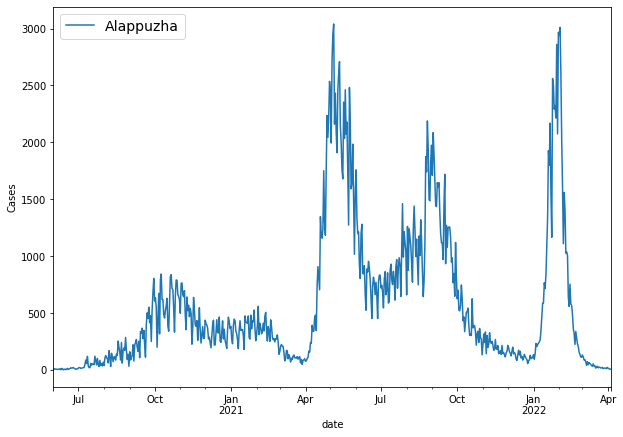

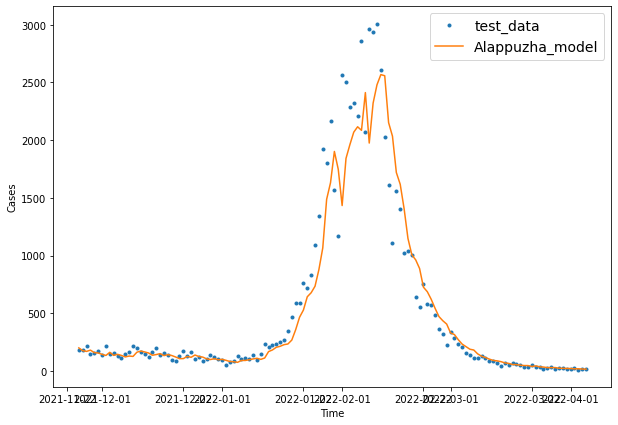

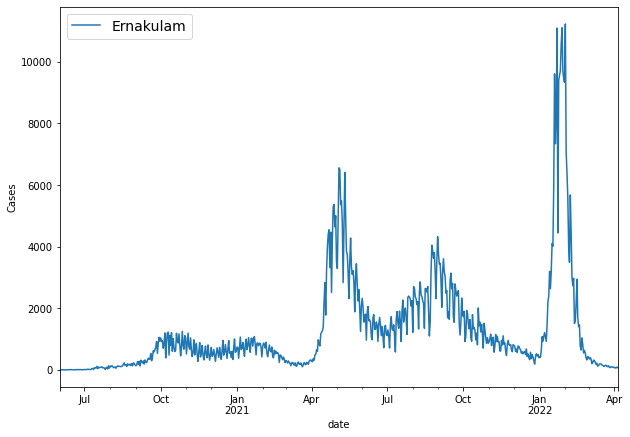

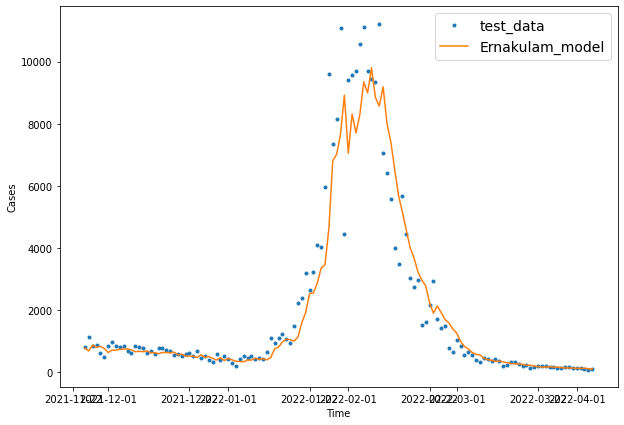

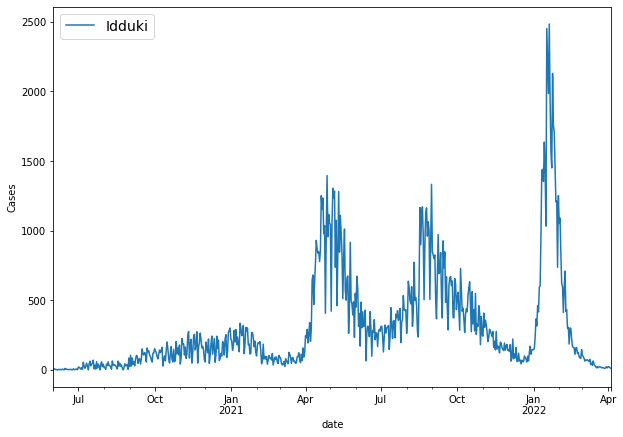

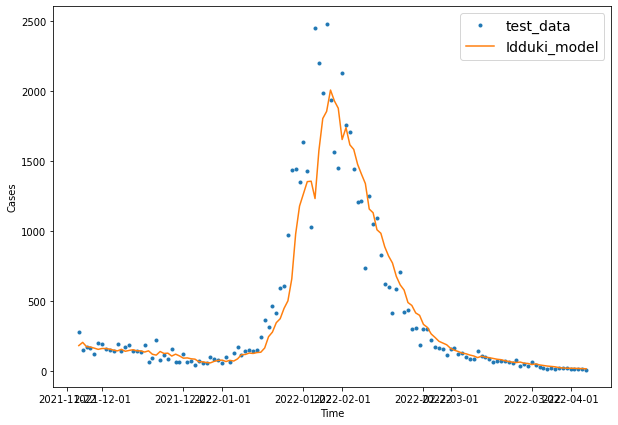

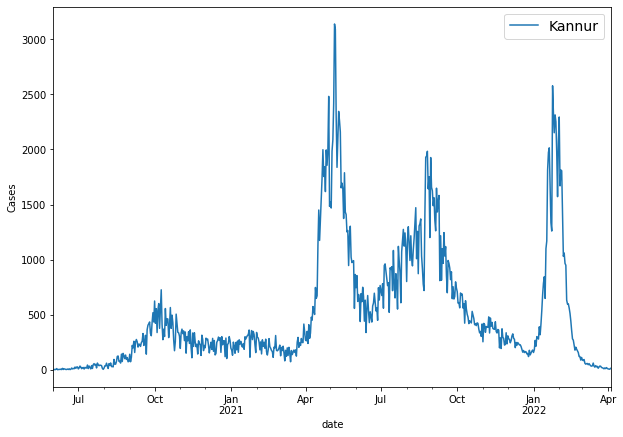

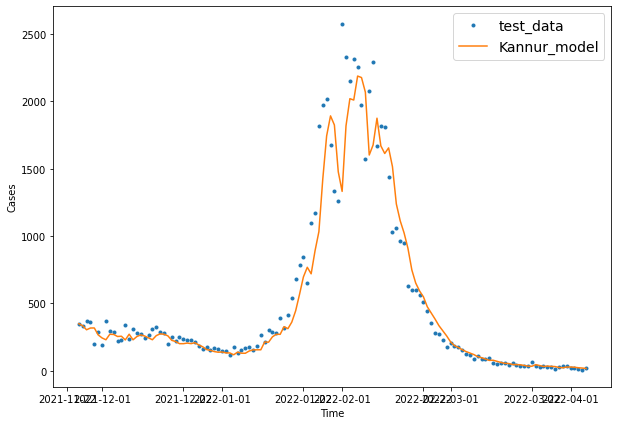

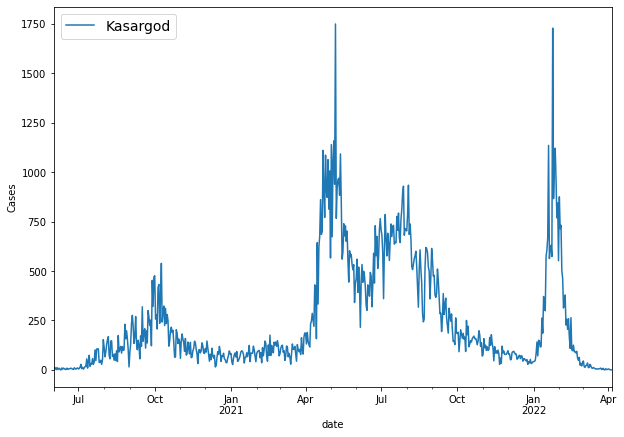

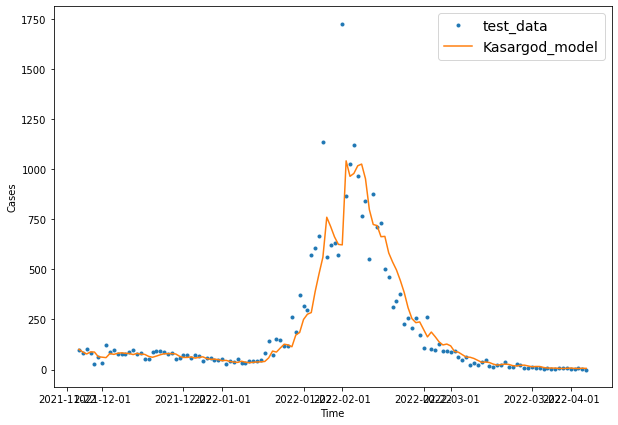

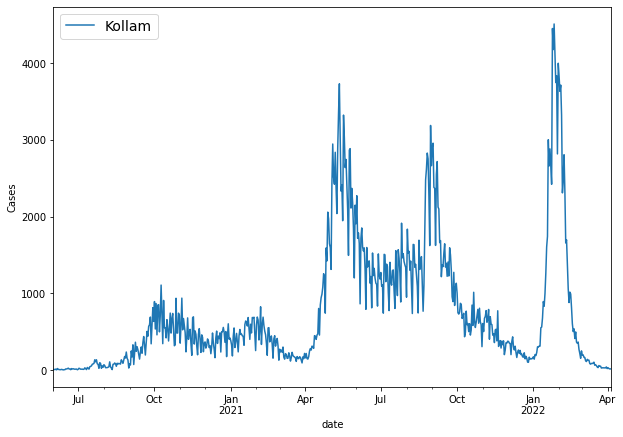

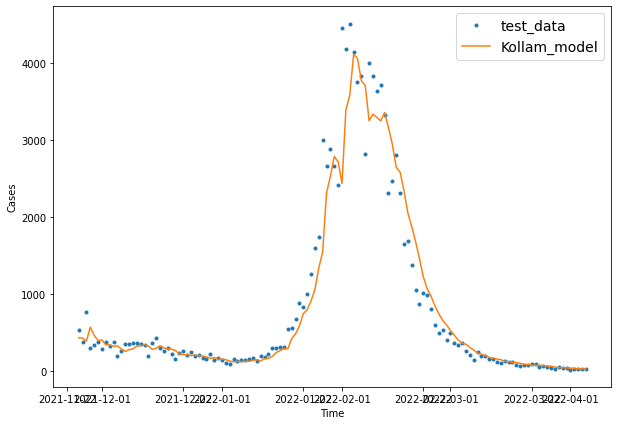

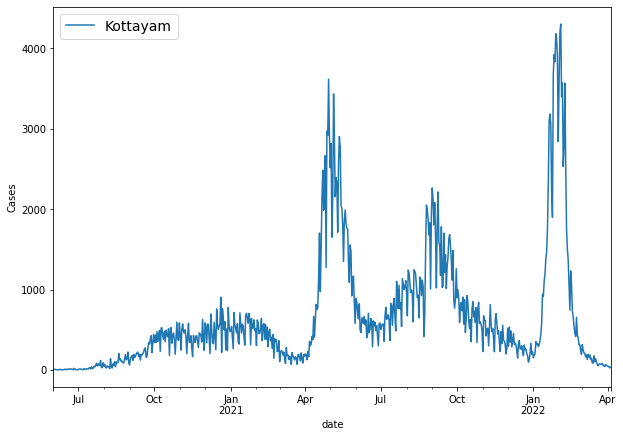

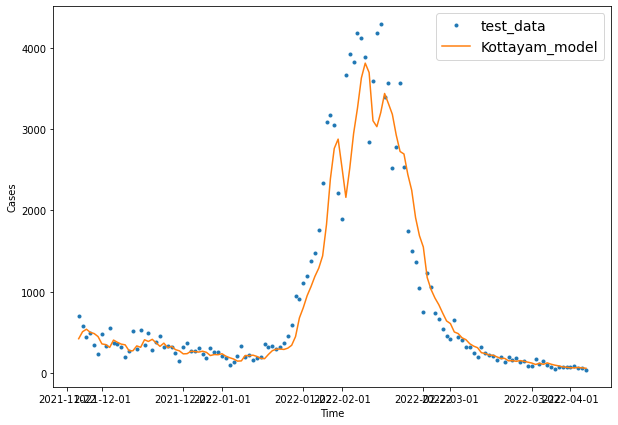

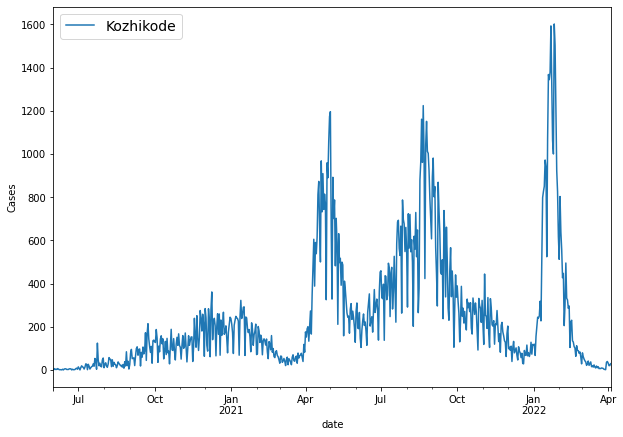

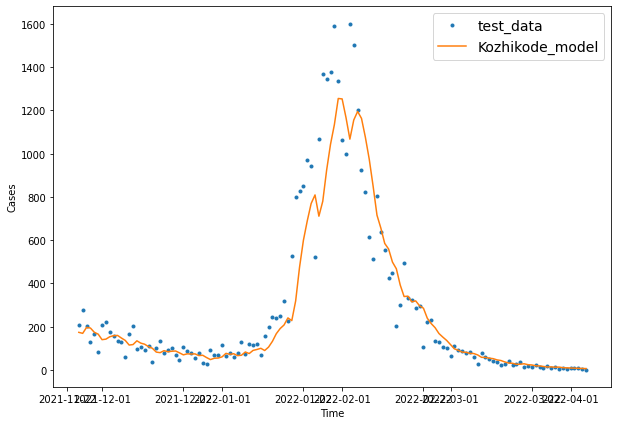

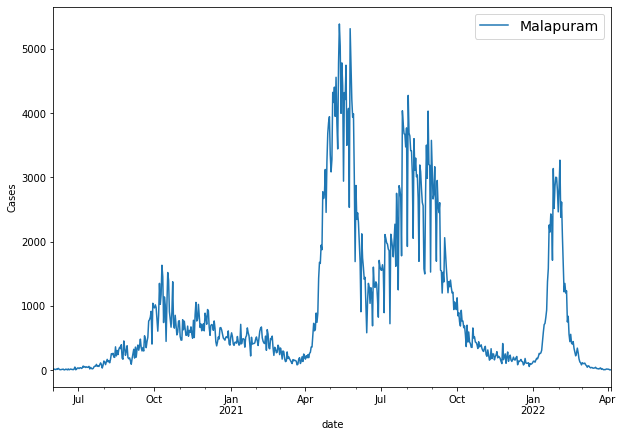

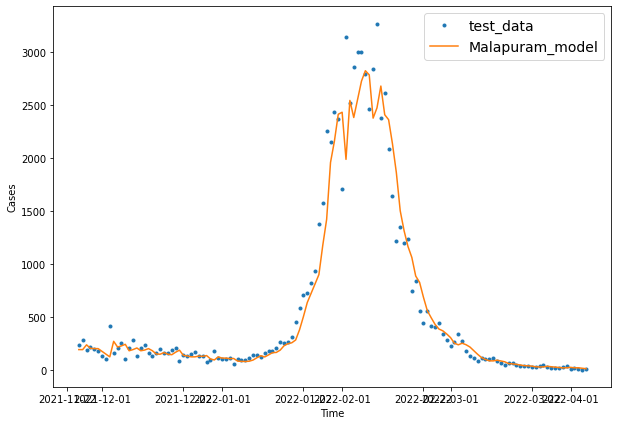

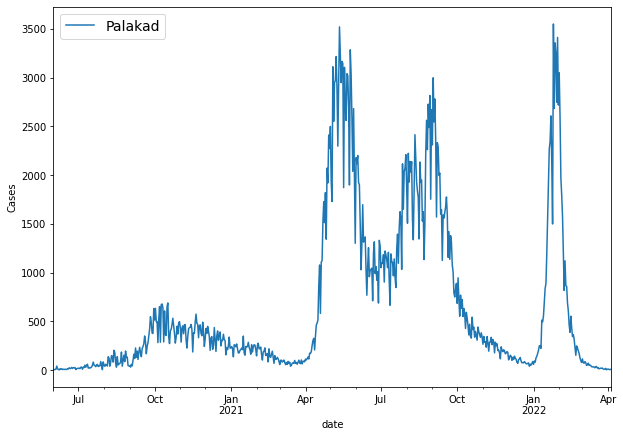

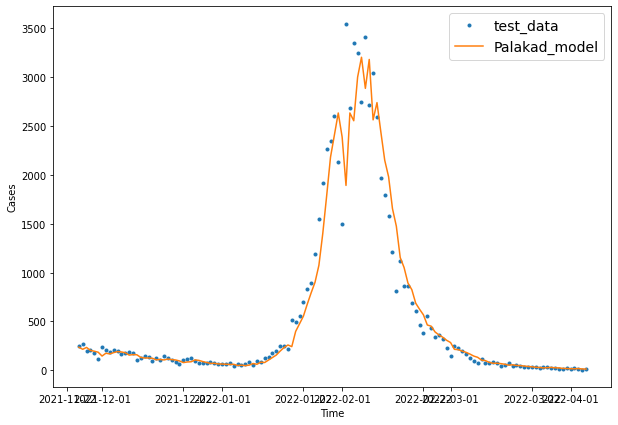

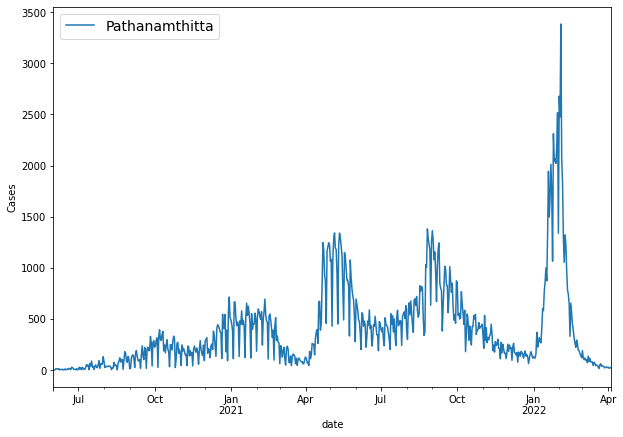

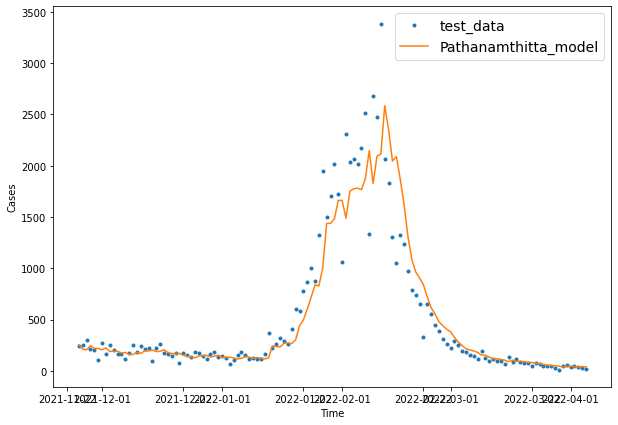

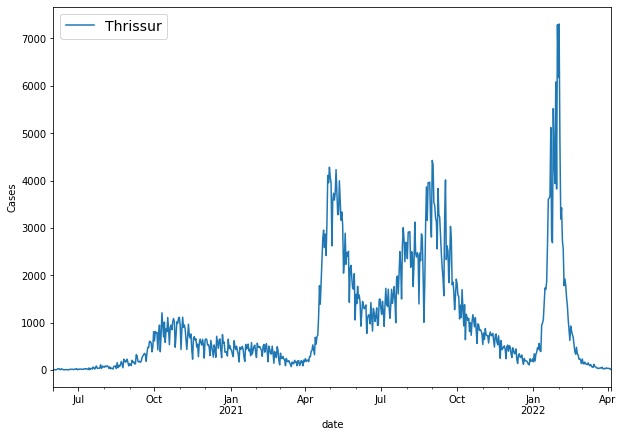

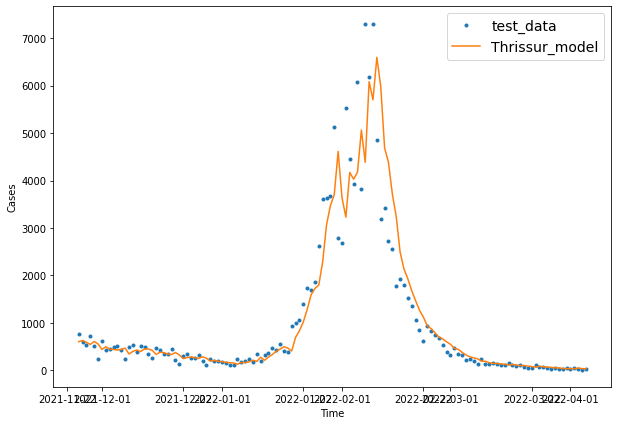

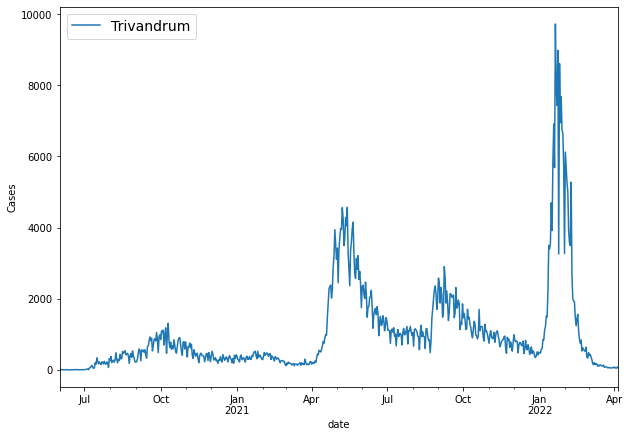

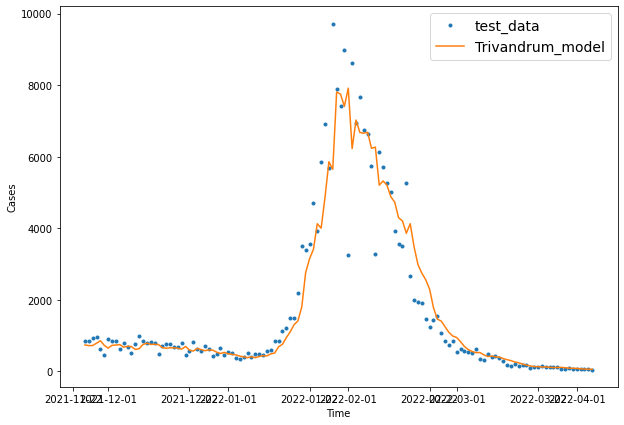

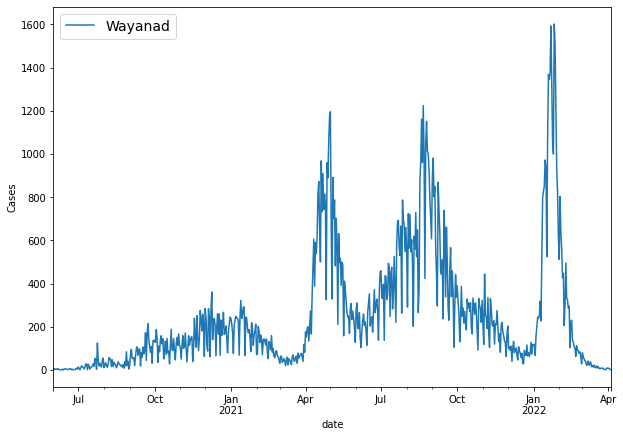

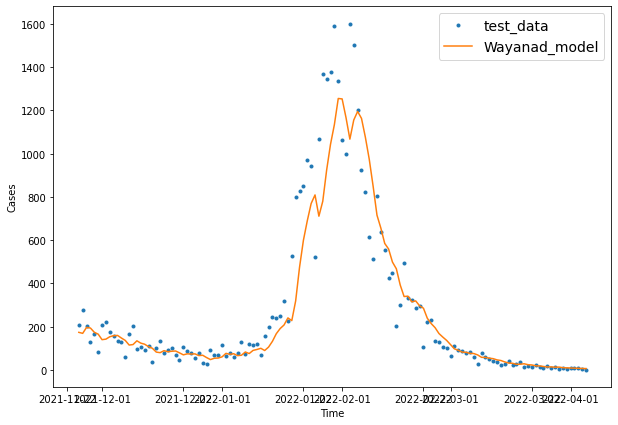

In [ ]:
list_of_models = {}
for i in districts_list:
    list_of_models[i] = load_and_train_model(filename = '/content/District .csv',
                                       district_name=i,
                                       horizon = 7,
                                       window_size = 7,
                                       name = f"{i}_model")

In [ ]:
for i in districts_list:
    list_of_models[i].save(f"{i}_model.h5")

In [ ]:
print(list_of_models)

{'Alappuzha': <keras.engine.sequential.Sequential object at 0x7f113b47bd50>, 'Ernakulam': <keras.engine.sequential.Sequential object at 0x7f1144db8790>, 'Idduki': <keras.engine.sequential.Sequential object at 0x7f1131874310>}
